## Needs emk_neuro_analysis environment

### Loads LFP, camera tracking positions and DIO

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter

from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

## Experiment parameters

In [2]:
# name of experiment
experiment_name = 'O3'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme0'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220505',]

# choose the epoch - as a list
epoch_list = [1,]

# choose the tetrodes - as a list
tet_list = [28, 27, 20, 19, 17, 16, 15, ]


## Build day records from track confi file and experiment file

In [3]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220505_01': {'date': '20220505',
                 'description': 'Closed-loop testing',
                 'end': Timestamp('2022-05-05 23:55:00'),
                 'experiment': 'O3',
                 'id': 1,
                 'name': 'stim',
                 'start': Timestamp('2022-05-05 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': 'O3',
                                       'description': 'S',
                                       'dio': {'11': {'bit': '_',
                                                      'notes': None,
                                                      'type': 'Unnamed:'},
                                               'entrance_sensor': {'bit': 1,
                                                                   'notes': None,
                                                                   'type': 'in'},
                                               'exit_sensor': {'bit': 3,
                                                     

In [4]:
def plot_freq_response(filter_name, order, lowcut, highcut, sampling_freq):
    
    if filter_name == 'elliptical': 
        sos = signal.ellip(order, 0.01, 120, [lowcut,highcut], btype = 'bp', output = 'sos', fs = sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut,highcut], 'bp', fs = sampling_freq, output='sos')
    if filter_name =='cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

   
    
    fig = plt.figure()
    w, h = signal.sosfreqz(sos, worN=2000)
    plt.plot((sampling_freq * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.axvline(x=lowcut)
    plt.axvline(x=highcut)
    plt.xlim([lowcut*.7,highcut*1.3])
    
    plt.ylim([-0.1, 1.05])

def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    """
    Return a dictionary of filtered lfp data

    :param filter_name: name of the filter you want to use
    :type filter_name: string
    :param flattened_array: array of the raw lfp data
    :type flattened_array: np array
    :param sampling_freq: frequency lfp data was sampled at
    :type sampling_freq: int
    :param order: order of filter
    :type order: int
    :param lowcut: lower border of frequencies allowed to pass
    :type lowcut: int
    :param highcut: upper border of frequencies allowed to pass
    :type highcut: int
    

    
   
    :return: filtered lfp data
    :rtype: np array

    """
    if filter_name == 'elliptical': 
        sos = signal.ellip(order, 0.01, 120, [lowcut,highcut], btype = 'bp', output = 'sos', fs = sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut,highcut], 'bp', fs = sampling_freq, output='sos')
    if filter_name =='cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)
    
    
    return y

def filter_bands(lfp_array, define_bands, sampling_freq, filter_name):
    """
    Return a dictionary of filtered lfp data

    :param lfp_array: array of the raw lfp data
    :type lfp_array: np array
    :param define_bands: dictionary where keys are the band names, values are lists that define the order, band lowcut, and band highcut
    :type define_bands: keys are strings, vals are lists of integers
    :param sampling_freq: sampling frequency for lfp recordings
    :type sampling_freq: int
    :param filter_name: name of the filter you want to use
    :type filter_name: string

    
   
    :return: keys are the names of the bands, vals are the lfp data for the filtered band
    :rtype: dictionary, keys are strings, vals are np arrays

    """
    flattened_array = lfp_array.flatten()
    bands = {}
    
    for key, val in define_bands.items():
            bands.update({key: bandpass_filter(filter_name, flattened_array, sampling_freq, 
                                               val[0], val[1], val[2])})
    
    
    return bands

def plot_lfp_overlays(bands_dict, band_name, epoch, row, sampling_freq, start, end):
    
    lfp_raw = bands_dict['raw'] #[epoch-1][row] 
    lfp_band = bands_dict[band_name] #[epoch-1][row]
    xvals = np.arange(0, len(lfp_band))/sampling_freq
    
    start = max(0, start * sampling_freq)
    if end != -1:
        end = min(len(xvals), end * sampling_freq)

#     fig = plt.figure()
    fig = plt.figure(figsize=(10,5))
    
    plt.plot(xvals[start : end], lfp_raw[start : end], color = 'lightgray', alpha = .8)
    plt.plot(xvals[start : end], lfp_band[start : end], color = 'red', linewidth = 1)
    
    plt.title('Entire signal with '+ band_name+' overlay')
#     return fig

# Set of frequency bands

define_bands = {'spike': [10, 600, 6000], }

#define_bands = {
#                'ripple': [20, 100, 250],}


def load_time(data_path):
    return readTrodesExtractedDataFile(data_path)




def load_mda(data_path):
    return readTrodesExtractedDataFile(data_path)


def extract_mda(lfp_raw, fs=1500):
    
    mda_data = mda_raw.get('data')
    mda_data = [i[0] for i in mda_data]
    indstart = 0
    indend = len(lfp_data)
    mda_timestamp = np.arange(indstart, indend)/(fs)
    
    return mda_data, mda_timestamp

def filter_linenoise(fs = 1500):
    f0 = 60  # Frequency to be removed from signal (Hz)
    Q = 30  # Quality factor
    # Design notch filter
    b, a = signal.iirnotch(f0, Q, fs)
    return {'b': b, 'a': a}
    

def remove_mda_linenoise(mda_input, filter_params):

    mda_output = signal.filtfilt(filter_params.get('b'), 
                                      filter_params.get('a'), 
                                      mda_input)
    return mda_output


def iterate_mda_load(tet_list, data_dir, fname_date, fname_exp, 
                     fname_task, fname_epoch, linenoise_filter_params={}, define_bands={}):
    mda_out = {}
    
    fdir = Path(data_dir, fname_date, f'{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.mountainsort')
    
    # list files
    
    for tet in tet_list:
                
        fpath_data = list(Path(fdir).rglob(f'*nt{tet}*mda'))
        fpath_time = list(Path(fdir).rglob(f'*time*mda'))
        if fpath_data:
            print(f'{tet} - data loaded')
        else:
            print(f'{tet} - data not found')
            continue
            
        pprint(fpath_data)
        mda_raw = mdaio.readmda(f'{fpath_data[0]}')
        mda_time = mdaio.readmda(f'{fpath_time[0]}')
        
        bands_dicts = [filter_bands(y, define_bands, 30000, 'elliptical') for y in mda_raw]
        
       # pprint(bands_dicts)
        
        mda_spike = [v.get('spike') for v in bands_dicts]
        #if linenoise_filter_params:
        #    mda_data = remove_mda_linenoise(mda_data, linenoise_filter_params)
        mda_out.update({tet: {'raw': mda_raw,
                              'spike': mda_spike,
                             'timestamp': mda_time}})
    
    return mda_out, fpath_data
        

In [5]:
dict_sensor_pump_map = {1: {'sensor': 'entrance_sensor'},
                        2: {'pump': 'stim_pump'},
                        6: {'sensor': 'Entrance_sensor'},
                        7: {'sensor': 'Exit_sensor'},
                        9: {'pump': 'reward 1 pump'},
                        }

# pump retrigger filter ms

filter_retrigger = 0

# get data for each animal

# get data for each animal

dict_list_animals = {'O3': ['O3', ]}

dict_colors = {'O3': 'tab:blue',}


dict_lines = {'1': '-',
              '2': '--'}

In [6]:
# File name format 
# eg. [fname_date]_[fname_exp]_[fname_epoch]_[fname_task].rec
# eg 20211222_clc_02_stim

# Day
fname_date = '20220505'

fname_exp = 'O3'

fname_task = 'stim'

fname_epoch = '01' # needs to be a string eg. '04'


# tetrodes to load, a list
tlist = [14, 15, 16, 17, 18, 19, ]
tlist = [15, ]
tlist = [27,]

# directory where your processed file is located
f_datadir = f'/media/{data_disk}/Data/{fname_exp}/preprocessing'


# initiate filter for 60Hz mains noise
linefilter = filter_linenoise()

# # load data
# dict_data, fpath_data = iterate_mda_load(tlist, f_datadir, fname_date, fname_exp, fname_task, fname_epoch, 
#                              linenoise_filter_params=linefilter, define_bands=define_bands)

# load timestamps
dir_time = f'{f_datadir}/{fname_date}/{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.time/'
path_time = f'{dir_time}{fname_date}_{fname_exp}_{fname_epoch}_{fname_task}.continuoustime.dat'
dict_time = load_time(path_time)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


In [7]:
# convert time to common scale
time_unix_start = int(dict_time.get('system_time_at_creation'))
time_internal_start = int(dict_time.get('timestamp_at_creation'))*-1
time_clockrate = int(dict_time.get('timestamp_at_creation'))

time_data = np.array(list(itertools.chain(*dict_time.get('data'))))

In [33]:
%matplotlib notebook
# get data for each animal

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=1)
tick_minutes_fmt = mdates.DateFormatter('%H:%M:%S.%f')
tick_minor = mdates.SecondLocator(interval=1)

# 
dict_dio_out = {}


# list dio
list_dio = [2, 6, 7, ]

y_label = ['Stim', 
           'Entrance', 
           'Exit'
            ]

# plot each session
curr_group = 'O3'
list_animals = dict_list_animals.get(curr_group)
for animal_id in list_animals:
    
    
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all, 
                                        experiment_name, trodes_version=2)

    cls_behavior.filter_animals(animal_id)

    print(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue

    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False, 
                                               output_raw=False, 
                                               filter_retrigger=None)
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False, 
                                         output_raw=False, 
                                         filter_retrigger=filter_retrigger)

    # get unique sessions
    sessions_unique = np.sort(df_pump['session'].unique())
    print(sessions_unique)
    
    n_subplots = len(sessions_unique)
    
#     fig = plt.figure(figsize=(8, n_subplots*2+2))
#     axs = fig.subplots(n_subplots, 1)
    
    if n_subplots == 1:
        axs = [axs, ]
        sessions_unique = [sessions_unique[0], ]
    
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):

       
        # get session times
        
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        
        # get sensor and pump times
        try:
            df_sensor_curr = df_sensor[df_sensor['session']==session]
            df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start) 
                                           & (df_sensor_curr['on_time_sys']<curr_end)]
        except:
            pass
        
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start) 
                                       & (df_pump_curr['on_time_sys']<curr_end)]

        
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        
        for i, d in enumerate(list_dio):
            #print(d)
            
            yval = i+1
            
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            #print(curr_pump_name)
            #display(df_plot_pump)
            
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            
            try:
                df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]

                # plot well triggers
                for ind, row in df_plot_sensor.iterrows():
                    ax.scatter(row['on_time_sys'], yval, s=25, c='k')
            except:
                pass

            for ind, row in df_plot_pump.iterrows():
                try:
                    ax.plot([row['on_time_sys'], 
                              row['off_time_sys']], [yval, yval], c='r')
                except:
                    pass

O3
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable
['20220505_01']


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

## Load LFP data

In [9]:
lfp_data, lfp_timestamp = lfp_iter.iterate_lfp_load(dir_preprocess, 
                                                    tet_list, 
                                                    choose_dates, 
                                                    epoch_list=epoch_list, 
                                                    remove_movement_artifact=False,
                                                    filter_linenoise=True,
                                                    print_debug=False)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 28
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 27
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 20
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 17
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 16
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.LFP tet 15
filter 60Hz noise


## Load position data

In [10]:
# this specifies the zoom factor on the camera
# needs to be measured 
# current setting of L17

cm_pix = {1: 0.3109,
          2: 0.05310,
          3: 0.3109,
          4: 0.05310,
          5: 0.3109,
          6: 0.05310,
          7: 0.3109,
         }


df_pos = pos_iter.iterate_pos_load(dir_preprocess, 
                                   date_list=choose_dates, 
                                   epoch_list=epoch_list, 
                                   cm_pix=cm_pix,
                                   print_debug=False)

1
Loaded /media/nvme0/Data/O3/preprocessing/20220505/20220505_O3_01_stim.1.pos


## Plot LFP, position, and speed

<IPython.core.display.Javascript object>


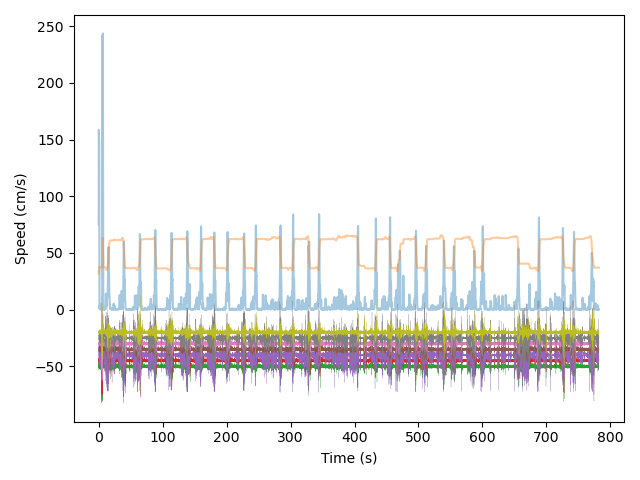

In [11]:
%matplotlib notebook

# sampling rate, convert raw timestamps to seconds on x-axis
fs = 30000

plt.figure()

# speed
plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.dxdydt_cm, zorder=-1, alpha=.4)

# position
# plt.plot(df_pos.time/fs, df_pos.xloc_smooth/10, zorder=-1, alpha=.4)
plt.plot((np.array(df_pos.time) - time_data[0])/fs, df_pos.yloc_smooth/10, zorder=-1, alpha=.4)

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
        plt.plot((np.array(lfp_timestamp.get(e))-time_data[0])/fs, np.array(v.get(e))/1000+5*(i-10), lw=.15)

plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.tight_layout()

## Stim, position and direction

In [34]:
# %matplotlib notebook

curr_dio = dict_dio_out.get(int(fname_epoch))

yval=0

# Position
# plt.plot((np.array(df_pos.time)-time_data[0])/fs, df_pos.yloc_smooth/10, zorder=-1, c='orange', alpha=.8)

# Speed
# plt.plot((np.array(df_pos.time)-time_data[0])/fs, df_pos.dxdydt_cm, zorder=-1, alpha=.4)

stim_timestamp = []
stim_time = []

for ind, row in curr_dio.iterrows():
    
    if row['dio'] == 'laser_pump':
        
        stim_timestamp.append(row['on_time'])
        stim_time.append((row['on_time'] - time_data[0])/30000)
        
#         plt.plot([(row['on_time'] - time_data[0])/30000, 
#                   (row['off_time'] - time_data[0])/30000], 
#                  #[yval+.15, yval+.15], c='r')
#                  [min(df_pos.yloc_smooth/10), max(df_pos.yloc_smooth/10)], c='r',alpha=0.5)

# legend placeholder
# plt.plot([0], [0], c='r', label='Stim = True')
# plt.plot([0],[0], c='orange', label='Position')
# plt.ylim([30,70])
# plt.legend()
# plt.xlabel('Time (s)')
# plt.ylabel('Position*0.1 (cm)')
# plt.title('Position and Stim events')

pos_timestamp = np.array(df_pos.time)
# replace stim timestamps with nearest position timestamps
stim_timestamp = pos_timestamp[[np.abs(pos_timestamp - s).argmin() 
                                for s in stim_timestamp]]

stim_ends = [0]

# identify the first and last stims in each trial
for i in range(len(stim_time)):
    
    try:
        if (stim_time[i+1]-stim_time[i]) > 5:
            stim_ends.extend([i, i+1])
            
    except IndexError:
        stim_ends.append(i)
    
# cut stim events into trials
stim_timestamp_cut = [stim_timestamp[start:end+1] 
                      for start, end in zip(stim_ends[::2], 
                                            stim_ends[1::2])]
stim_time_cut = [stim_time[start:end+1] 
                 for start, end in zip(stim_ends[::2], 
                                       stim_ends[1::2])]

In [35]:
reward_1_timestamp = []
reward_1_time = []

for ind, row in df_sensor_curr.iterrows():
    
    if row['dio'] == 'reward_1_sensor':
        
        reward_1_timestamp.extend([row['on_time'], row['off_time']])
        reward_1_time.append(((row['on_time']-time_data[0])/fs, 
                              (row['off_time']-time_data[0])/fs))

# replace reward timestamps with nearest position timestamps
reward_1_timestamp = tuple(zip(pos_timestamp[[np.abs(pos_timestamp - r).argmin() 
                                              for r in reward_1_timestamp[::2]]],
                               pos_timestamp[[np.abs(pos_timestamp - r).argmin() 
                                              for r in reward_1_timestamp[1::2]]]
                            ))

reward_1_ends = [0]

# identify the first and last stims in each trial
for i in range(len(reward_1_time)):
    
    try:
        if (reward_1_time[i+1][1]-reward_1_time[i][1]) > 20:
            reward_1_ends.extend([i, i+1])
            
    except IndexError:
        reward_1_ends.append(i)
        
# cut reward events into trials
reward_1_timestamp_cut = [reward_1_timestamp[start:end+1] 
                      for start, end in zip(reward_1_ends[::2], 
                                            reward_1_ends[1::2])]
reward_1_time_cut = [reward_1_time[start:end+1] 
                 for start, end in zip(reward_1_ends[::2], 
                                       reward_1_ends[1::2])]

<IPython.core.display.Javascript object>


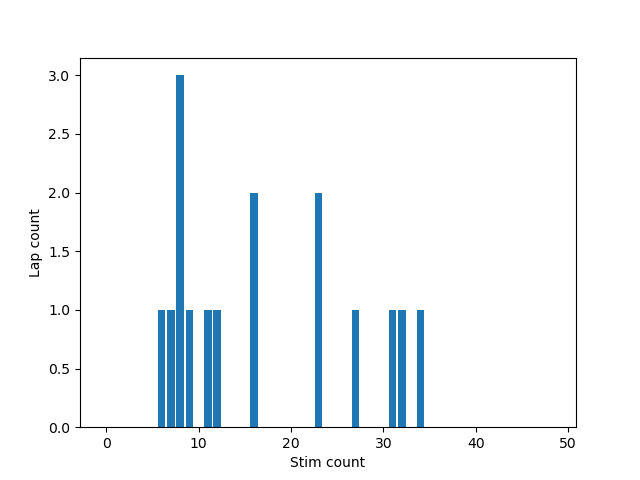

Text(0.5, 0, 'Stim count')

In [36]:
%matplotlib notebook

# distribution of stimulation counts across laps

lap_count = np.subtract(stim_ends[1::2],stim_ends[::2])

on_xcorr_hist,on_bin_edges = np.histogram(lap_count,range(0,50))

plt.bar(on_bin_edges[:-1],
        on_xcorr_hist,
       )

# plt.legend()
plt.ylabel('Lap count')
plt.xlabel('Stim count')

<IPython.core.display.Javascript object>


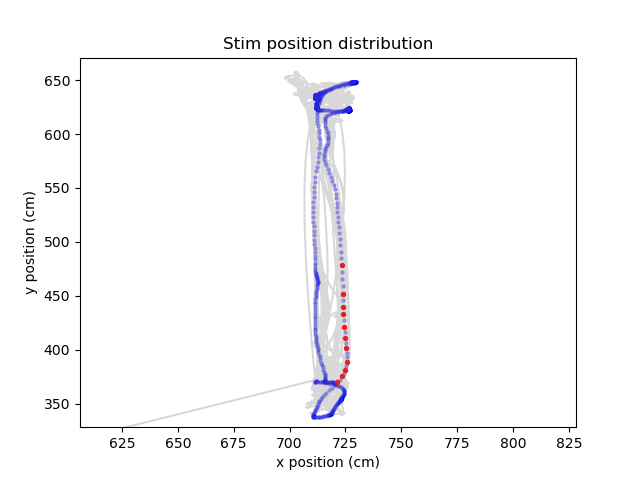

Text(0.5, 1.0, 'Stim position distribution')

In [100]:
# position distribution of stimulation
%matplotlib notebook

plot_all = False

trial = 15

if plot_all:
    
    # Position data of ALL stim
    stim_pos = np.array([df_pos.loc[df_pos['time']==t, 
                                    ['xloc_smooth', 'yloc_smooth']].values[0] 
                                   for t in stim_timestamp]) 

else:
    
    # Position data for stim in particular trial
    stim_pos = np.array([df_pos.loc[df_pos['time']==t, 
                                    ['xloc_smooth', 'yloc_smooth']].values[0] 
                                   for t in stim_timestamp_cut[trial]])
    
    # Position data in particular trial
    try:
        trial_pos = df_pos.loc[(df_pos['time'] >= reward_1_timestamp_cut[trial-1][-1][-1]) &
                                  (df_pos['time'] <= reward_1_timestamp_cut[trial][-1][1]),
                                ['xloc_smooth', 'yloc_smooth']].values

    except IndexError:
        # trial = 0
        trial_pos = df_pos.loc[(df_pos['time'] <= reward_1_timestamp_cut[0][-1][1]),
                                ['xloc_smooth', 'yloc_smooth']].values

# all trajectories across trials
plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3,)
plt.scatter(trial_pos[:,0],trial_pos[:,1], s=5, c='b', alpha=.3)
plt.scatter(stim_pos[:,0],stim_pos[:,1], s=8, c='r', alpha=1)

plt.xlabel('x position (cm)')
plt.ylabel('y position (cm)')
plt.title('Stim position distribution')

In [38]:
# %matplotlib notebook

# on_xcorr_hist,on_bin_edges = np.histogram(np.around(stim_pos_y,decimals=0),
#                                           range(int(min(df_pos.get('yloc_smooth')))-5,
#                                                 int(max(df_pos.get('yloc_smooth')))+5))

# plt.bar(on_bin_edges[:-1],
#         on_xcorr_hist)

# plt.axvline(x=min(df_pos.get('yloc_smooth')), linestyle='--',c='r')
# plt.axvline(x=max(df_pos.get('yloc_smooth')), linestyle='--',c='r')

In [113]:
# Examine the stims in wrong direction

'''
signed gradient of position; in principle the rat wouldn't go
backwards in the stim zone. Imperfect percentage can be caused
by early tail trigger (then pos gradient < 0) when it turns 
its body around
'''

df_pos_2 = df_pos
df_pos_2['velocity'] = np.gradient(df_pos.get('yloc_smooth'))

stim_post_vel = []
stim_neg_vel = []

for t in stim_timestamp:
    if df_pos.loc[df_pos['time']==t, 'velocity'].values[0] < 0:
        stim_neg_vel.append(t)
    else:
        stim_post_vel.append(t)

print(str(100-len(stim_neg_vel)*100/len(stim_timestamp))
      +"% of the stims have correct directionality")

79.79094076655052% of the stims have correct directionality


<IPython.core.display.Javascript object>


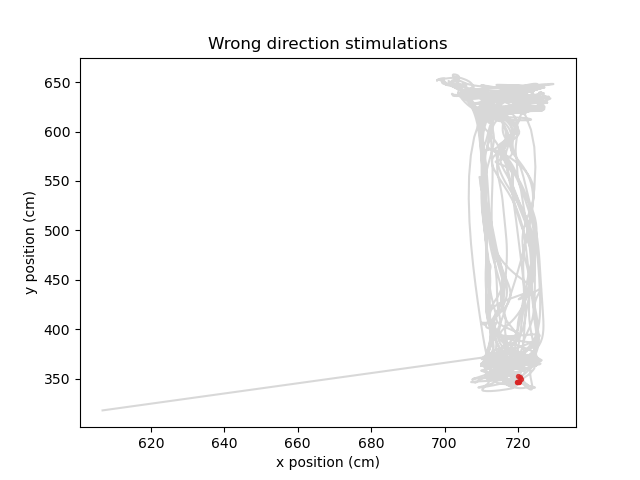

Text(0.5, 1.0, 'Wrong direction stimulations')

In [101]:
%matplotlib notebook

# hypothesis: most (if not all) stims of negative velocity should be in the reward
# zone, cuz those are probably triggered by tail

# cut wrong stims into trials
stim_neg_vel_cut = [[] for i in range(len(stim_timestamp_cut))]

for i in range(len(stim_timestamp_cut)):
    stim_neg_vel_cut[i] = np.array(stim_neg_vel)[np.isin(np.array(stim_neg_vel), 
                                                         stim_timestamp_cut[i])]

plot_all = False
    
trial = 1

if plot_all:
    # all stims of wrong directionality
    stim_neg_pos = np.array([df_pos.loc[df_pos['time']==t, 
                                        ['xloc_smooth','yloc_smooth']].values[0] 
                                       for t in stim_neg_vel]) 

else:
    # stims of wrong directionality in particular trial
    stim_neg_pos = np.array([df_pos.loc[df_pos['time']==t, 
                                        ['xloc_smooth', 'yloc_smooth']].values[0] 
                                       for t in stim_neg_vel_cut[trial]]) 

# all trajectories across trials
plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3)

plt.scatter(stim_neg_pos[:,0],stim_neg_pos[:,1], s=8, c='r', alpha=.8)

plt.xlabel('X position (cm)')
plt.ylabel('Y position (cm)')
plt.title('Wrong direction stimulations')

<IPython.core.display.Javascript object>


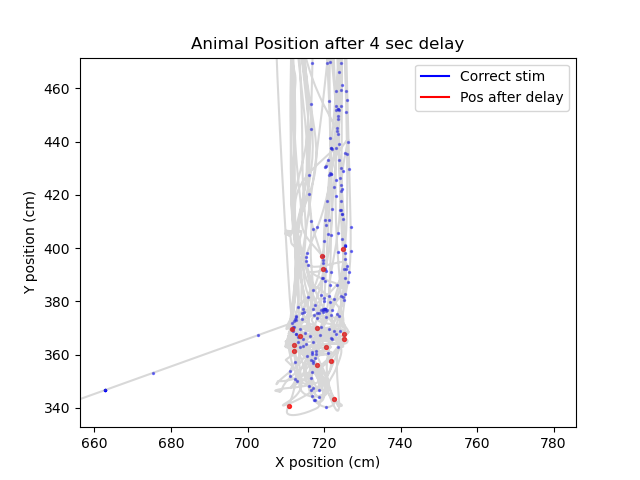

Text(0.5, 1.0, 'Animal Position after 4 sec delay')

In [122]:
%matplotlib notebook

# get the position of rat at a certain amount of delay
# after departure from reward well

delay_period = 4 # in secs
delayed_timestamp = [r[-1][-1]+delay_period*fs for r in reward_1_timestamp_cut]

delayed_timestamp = pos_timestamp[[np.abs(pos_timestamp - d).argmin() 
                                    for d in delayed_timestamp]]

# all trajectories across trials
plt.plot(df_pos.get('xloc_smooth'), df_pos.get('yloc_smooth'), c='gray', alpha=.3)

# animal's positions at the end of delay period
delay_pos = np.array([df_pos.loc[df_pos['time']==t, 
                                       ['xloc_smooth', 'yloc_smooth']].values[0] 
                                 for t in delayed_timestamp])

# stims correctly triggered (not by tail) with old logic
correct_stim_pos = np.array([df_pos.loc[df_pos['time']==t, 
                                       ['xloc_smooth', 'yloc_smooth']].values[0] 
                            for t in stim_post_vel])

plt.scatter(correct_stim_pos[:,0],correct_stim_pos[:,1], s=2, c='b', alpha=.5)

plt.scatter(delay_pos[:,0],delay_pos[:,1], s=8, c='r', alpha=.8)

# legend placeholder
plt.plot([0],[0], c='b', label='Correct stim')
plt.plot([0],[0], c='r', label='Pos after delay')
plt.legend()
plt.xlabel('X position (cm)')
plt.ylabel('Y position (cm)')
plt.title('Animal Position after %d sec delay' % delay_period)

## Stim and Phase